<center>
<img src="../../img/ml_theme.png">
# Майнор "Интеллектуальный анализ данных" 
# Курс "Введение в анализ данных"
<img src="../../img/faculty_logo.jpg" height="240" width="240">
## Автор материала: преподаватель ФКН НИУ ВШЭ Кашницкий Юрий
</center>
Материал распространяется на условиях лицензии <a href="http://www.microsoft.com/en-us/openness/default.aspx#Ms-RL">Ms-RL</a>. Можно использовать в любых целях, но с обязательным упоминанием автора курса и аффилиации.

# Семинары 5 и 6. Линейные модели в машинном обучении

## Часть 3. Логистическая регрессия и регуляризация

In [41]:
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
from math import log, exp, sqrt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


**Считываем данные.**

In [42]:
data = pd.read_csv('../../data/2d_data.csv', header=None)
data.columns = ['Class', 'x1', 'x2']

In [43]:
data.head()

,Class,x1,x2
0,-1,-0.663827,-0.138526
1,1,1.994596,2.468025
2,-1,-1.247395,0.749425
3,1,2.309374,1.899836
4,1,0.849143,2.407750


In [44]:
data.describe()

,Class,x1,x2
count,205.00000,205.000000,205.000000
mean,0.02439,0.703925,0.681453
std,1.00215,2.332041,2.546902
min,-1.00000,-12.977800,-17.677268
25%,-1.00000,-0.264257,-0.206879
50%,1.00000,1.014348,1.027139
75%,1.00000,2.048088,2.032488
max,1.00000,4.465992,4.228316


**Данные двухмерные. Отобразим их.**

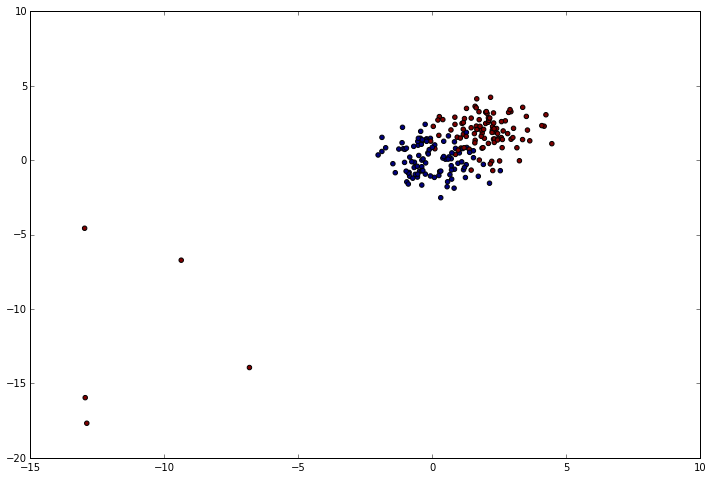

In [45]:
figsize(12,8)
scatter(data['x1'], data['x2'], c=data['Class'])

**Напишем функцию, вычисляющую логистическую функцию потерь с регуляризацией. 
$$\Large log\_loss(x, y, \beta) = - \frac{1}{n}\sum_{i=1}^n ln\sigma(y^{(i)}\beta^Tx^{(i)}) + \frac{1}{2}C\ {||\beta||}^2$$**

In [46]:
def log_loss(train_df, beta0, beta1, beta2, reg_param):
    margins = train_df['Class']*(beta0 + beta1 * train_df['x1'] + beta2 * train_df['x2'])
    return margins.apply(lambda x: log(1 + exp(-x))).sum() / float(train_df.shape[0]) +\
            0.5 * reg_param * (beta1 ** 2 + beta2 ** 2)

In [47]:
print(log_loss(data, 0, 0, 0, 0.1))

0.69314718056


**Ответом алгоритма является вероятность отнесения к классу "+1": 
$$\Large a(x) = Pr(y = +1|X = x) = \frac{1}{1 + exp^{-\beta x}}$$**

In [48]:
def a(train_df, beta0, beta1, beta2):
    return (beta0 + beta1 * train_df['x1'] + beta2 * train_df['x2']).apply(lambda x: 1. / (1 + exp(-x)))

**Реализуем градиентный спуск.
Веса на каждом шаге обновляются по правилу
$$\Large \beta_0 = \beta_0 + \frac{\nu}{n} \sum_{i=1}^n{y^{(i)} \sigma(y^{(i)}\beta^T{x_j}^{(i)})}$$
$$\Large \beta_j = \beta_j + \frac{\nu}{n} \sum_{i=1}^n{y^{(i)}{x_j}^{(i)} \sigma(y^{(i)}\beta^T{x_j}^{(i)})} - \nu C \beta_j$$
Здесь $j \in \{1,2\}, \nu$ - параметр (шаг градиентного спуска).
**

In [49]:
def grad_step(train_df, beta0, beta1, beta2, reg_param, step, regularize=True):
    margins = train_df['Class']*(beta0 + beta1 * train_df['x1'] + beta2 * train_df['x2'])
    margins = margins.apply(lambda x: 1 - 1./(1 + exp(-x)))
    x0_grad = x2_grad = (train_df['Class'] * margins).sum() / float(train_df.shape[0])
    x1_grad = (train_df['Class'] * train_df['x1'] * margins).sum() / float(train_df.shape[0])
    x2_grad = (train_df['Class'] * train_df['x2'] * margins).sum() / float(train_df.shape[0])
    new_beta0 = beta0 + step * x0_grad
    new_beta1 = beta1 + step * x1_grad
    new_beta2 = beta2 + step * x2_grad
    if regularize:
        new_beta1 -= step * reg_param * beta1
        new_beta2 -= step * reg_param * beta2
    return new_beta0, new_beta1, new_beta2

In [50]:
def grad_descent(train_df, error_func, 
                 init_point=(0, 0, 0), step=0.1, regularize=True,
                max_iter=10000, max_error=1e-5, reg_param=0.1):
    beta0, beta1, beta2 = init_point
    for i in range(max_iter):
        beta0, beta1, beta2 = grad_step(train_df, beta0, beta1, beta2, reg_param, step,
                          regularize=regularize)
        new_error = error_func(train_df, beta0, beta1, beta2, reg_param)
        if new_error <= max_error:
            return beta1, beta2, new_error
    return beta0, beta1, beta2, new_error

**Запуск без регуляризации.**

In [51]:
beta0_no_regul, beta1_no_regul, beta2_no_regul, loss_no_regul = grad_descent(data, log_loss, step=0.1, regularize=False,
                           init_point=(0, 0, 0), max_iter=1000)

In [52]:
beta0_no_regul, beta1_no_regul, beta2_no_regul, loss_no_regul

(-0.44730988000693384,
 0.3868878191571307,
 0.17570751336372273,
 0.6339517909634153)

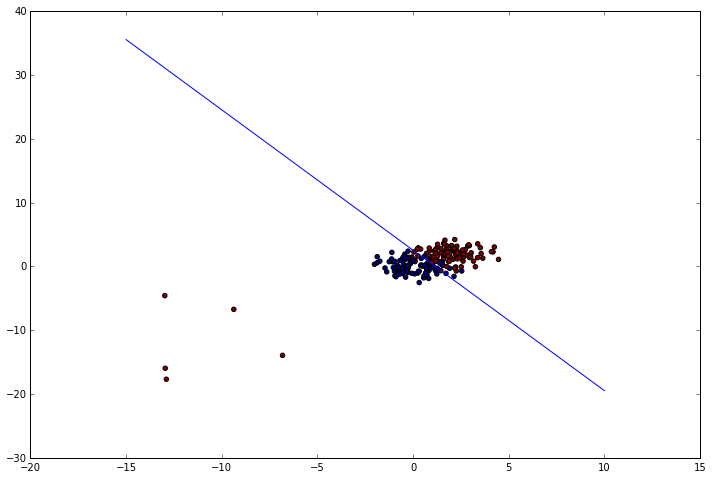

In [53]:
figsize(12,8)
scatter(data['x1'], data['x2'], c=data['Class'])
xx = range(-15,11)
plot(xx, [- beta0_no_regul / beta2_no_regul - beta1_no_regul / beta2_no_regul * x1 for x1 in xx])

**Градиентный спуск с регуляризацией. Случай малого значения С (слабая регуляризация)**

In [54]:
beta0_with_regul, beta1_with_regul, beta2_with_regul, loss_with_regul = grad_descent(data, log_loss, step=0.1,
                           init_point=(0, 0, 0), reg_param=0.05,
                           regularize=True, max_iter=1000)

In [55]:
beta0_with_regul, beta1_with_regul, beta2_with_regul, loss_with_regul

(-0.40380944611914876,
 0.3431472800589764,
 0.17349472883379233,
 0.6290022103524517)

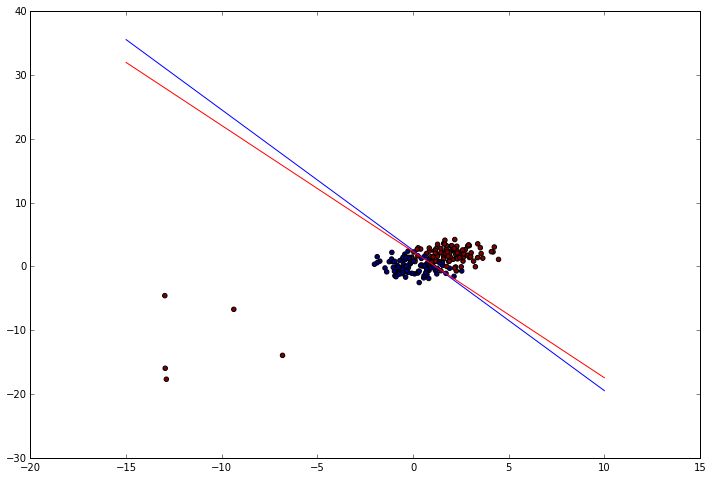

In [56]:
figsize(12,8)
scatter(data['x1'], data['x2'], c=data['Class'])
xx = range(-15,11)
plot(xx, [- beta0_no_regul / beta2_no_regul - beta1_no_regul / beta2_no_regul * x1 for x1 in xx])
plot(xx, [- beta0_with_regul / beta2_with_regul - beta1_with_regul / beta2_with_regul * x1 for x1 in xx], color='red')

**Градиентный спуск с регуляризацией. Случай большого значения С (сильная регуляризация)**

In [57]:
beta0_with_regul, beta1_with_regul, beta2_with_regul, loss_with_regul = grad_descent(data, log_loss, step=0.1,
                           init_point=(0, 0, 0), reg_param=10,
                           regularize=True, max_iter=1000)

In [58]:
beta0_with_regul, beta1_with_regul, beta2_with_regul, loss_with_regul

(0.011624295816306968,
 0.02839098063775941,
 0.024620759874023096,
 0.6840292829176104)

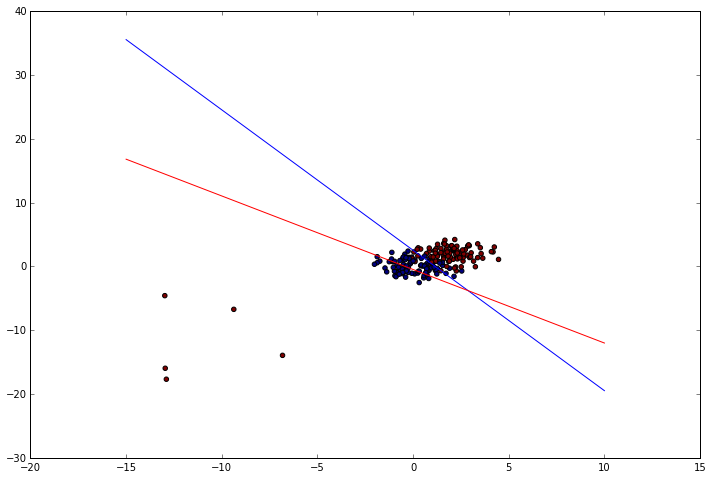

In [59]:
figsize(12,8)
scatter(data['x1'], data['x2'], c=data['Class'])
xx = range(-15,11)
plot(xx, [- beta0_no_regul / beta2_no_regul - beta1_no_regul / beta2_no_regul * x1 for x1 in xx])
plot(xx, [- beta0_with_regul / beta2_with_regul - beta1_with_regul / beta2_with_regul * x1 for x1 in xx], color='red')

**Метод плохо работает в случае признаков разного масштаба.**

In [60]:
data['x2'] = 50 * data['x2']

In [61]:
beta0_with_regul, beta1_with_regul, beta2_with_regul, loss_with_regul = grad_descent(data, log_loss, step=0.1,
                           init_point=(0, 0, 0), reg_param=10,
                           regularize=True, max_iter=1000)

In [62]:
loss_with_regul

183.76860769080042

Ошибка очень велика.